In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfield
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
# # Best Hyperparameters so far
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([0.15, 0.12])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 5
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.5
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.75, 0.5]), 'fb': np.array([0.15, 0.15])}

neural_lr_start = 0.1
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False


model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# _ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
#                                           neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                           neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

In [ ]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 50

for epoch_ in range(n_epochs):
    if epoch_ < 20:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [01:56, 25.74it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9275333333333333, Test Accuracy : 0.9301
Free Information ratio: [0.1788257]
Nudged Information ratio: [0.17882547]


3000it [01:26, 34.74it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.9522666666666667, Test Accuracy : 0.9475
Free Information ratio: [0.17192457]
Nudged Information ratio: [0.17192425]


3000it [01:57, 25.55it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.9664166666666667, Test Accuracy : 0.9622
Free Information ratio: [0.15911412]
Nudged Information ratio: [0.15911377]


3000it [01:47, 27.83it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.9709333333333333, Test Accuracy : 0.9655
Free Information ratio: [0.1530245]
Nudged Information ratio: [0.1530241]


3000it [01:52, 26.65it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.9751333333333333, Test Accuracy : 0.967
Free Information ratio: [0.14616934]
Nudged Information ratio: [0.14616894]


3000it [01:22, 36.16it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.9781333333333333, Test Accuracy : 0.969
Free Information ratio: [0.11775288]
Nudged Information ratio: [0.1177525]


3000it [01:22, 36.35it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.9795166666666667, Test Accuracy : 0.972
Free Information ratio: [0.13237198]
Nudged Information ratio: [0.13237151]


3000it [01:22, 36.31it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.9809166666666667, Test Accuracy : 0.9713
Free Information ratio: [0.14397598]
Nudged Information ratio: [0.1439756]


3000it [01:22, 36.34it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.9821166666666666, Test Accuracy : 0.9727
Free Information ratio: [0.10447749]
Nudged Information ratio: [0.10447703]


3000it [01:21, 36.78it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.98325, Test Accuracy : 0.9734
Free Information ratio: [0.1001594]
Nudged Information ratio: [0.10015898]


3000it [01:21, 36.86it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.9842166666666666, Test Accuracy : 0.9735
Free Information ratio: [0.10071546]
Nudged Information ratio: [0.10071505]


3000it [01:21, 36.60it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.9844666666666667, Test Accuracy : 0.9726
Free Information ratio: [0.09860697]
Nudged Information ratio: [0.09860661]


3000it [01:21, 36.59it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.9848333333333333, Test Accuracy : 0.9735
Free Information ratio: [0.07827893]
Nudged Information ratio: [0.07827858]


3000it [01:21, 36.76it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.9848333333333333, Test Accuracy : 0.9729
Free Information ratio: [0.08740969]
Nudged Information ratio: [0.08740935]


3000it [01:38, 30.46it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.98535, Test Accuracy : 0.9736
Free Information ratio: [0.09331601]
Nudged Information ratio: [0.09331569]


3000it [01:21, 36.87it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.98505, Test Accuracy : 0.9731
Free Information ratio: [0.08692985]
Nudged Information ratio: [0.08692953]


3000it [01:22, 36.36it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.9848666666666667, Test Accuracy : 0.9735
Free Information ratio: [0.08365271]
Nudged Information ratio: [0.0836524]


3000it [01:22, 36.46it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.98535, Test Accuracy : 0.9729
Free Information ratio: [0.0755289]
Nudged Information ratio: [0.07552857]


3000it [01:21, 36.82it/s]
0it [00:00, ?it/s]

Epoch : 19, Train Accuracy : 0.9861833333333333, Test Accuracy : 0.9731
Free Information ratio: [0.0731783]
Nudged Information ratio: [0.07317802]


3000it [01:22, 36.53it/s]
0it [00:00, ?it/s]

Epoch : 20, Train Accuracy : 0.9856666666666667, Test Accuracy : 0.9728
Free Information ratio: [0.07338672]
Nudged Information ratio: [0.07338645]


3000it [01:21, 36.79it/s]
0it [00:00, ?it/s]

Epoch : 21, Train Accuracy : 0.98645, Test Accuracy : 0.9738
Free Information ratio: [0.07655113]
Nudged Information ratio: [0.07655085]


3000it [01:22, 36.33it/s]
0it [00:00, ?it/s]

Epoch : 22, Train Accuracy : 0.9864, Test Accuracy : 0.9737
Free Information ratio: [0.06882302]
Nudged Information ratio: [0.06882272]


3000it [01:21, 36.81it/s]
0it [00:00, ?it/s]

Epoch : 23, Train Accuracy : 0.9864333333333334, Test Accuracy : 0.9741
Free Information ratio: [0.06370521]
Nudged Information ratio: [0.06370493]


3000it [01:22, 36.37it/s]
0it [00:00, ?it/s]

Epoch : 24, Train Accuracy : 0.9864333333333334, Test Accuracy : 0.974
Free Information ratio: [0.06773245]
Nudged Information ratio: [0.06773216]


3000it [01:23, 36.14it/s]
0it [00:00, ?it/s]

Epoch : 25, Train Accuracy : 0.9866, Test Accuracy : 0.9737
Free Information ratio: [0.07003075]
Nudged Information ratio: [0.07003047]


3000it [01:22, 36.46it/s]
0it [00:00, ?it/s]

Epoch : 26, Train Accuracy : 0.9864166666666667, Test Accuracy : 0.9736
Free Information ratio: [0.06509442]
Nudged Information ratio: [0.06509415]


3000it [01:22, 36.53it/s]
0it [00:00, ?it/s]

Epoch : 27, Train Accuracy : 0.9863833333333333, Test Accuracy : 0.9737
Free Information ratio: [0.06212042]
Nudged Information ratio: [0.06212016]


3000it [01:21, 36.70it/s]
0it [00:00, ?it/s]

Epoch : 28, Train Accuracy : 0.9863, Test Accuracy : 0.9736
Free Information ratio: [0.06354127]
Nudged Information ratio: [0.06354104]


3000it [01:20, 37.07it/s]
0it [00:00, ?it/s]

Epoch : 29, Train Accuracy : 0.98655, Test Accuracy : 0.9737
Free Information ratio: [0.06042892]
Nudged Information ratio: [0.06042867]


3000it [01:21, 36.80it/s]
0it [00:00, ?it/s]

Epoch : 30, Train Accuracy : 0.9864333333333334, Test Accuracy : 0.9737
Free Information ratio: [0.06321881]
Nudged Information ratio: [0.06321856]


3000it [01:22, 36.48it/s]
0it [00:00, ?it/s]

Epoch : 31, Train Accuracy : 0.9863666666666666, Test Accuracy : 0.9737
Free Information ratio: [0.07039315]
Nudged Information ratio: [0.07039292]


3000it [01:21, 36.67it/s]
0it [00:00, ?it/s]

Epoch : 32, Train Accuracy : 0.9863666666666666, Test Accuracy : 0.9732
Free Information ratio: [0.05546526]
Nudged Information ratio: [0.05546502]


3000it [01:21, 36.72it/s]
0it [00:00, ?it/s]

Epoch : 33, Train Accuracy : 0.98635, Test Accuracy : 0.9731
Free Information ratio: [0.06008052]
Nudged Information ratio: [0.06008028]


3000it [01:22, 36.58it/s]
0it [00:00, ?it/s]

Epoch : 34, Train Accuracy : 0.9863333333333333, Test Accuracy : 0.9733
Free Information ratio: [0.06170108]
Nudged Information ratio: [0.06170083]


3000it [01:21, 36.60it/s]


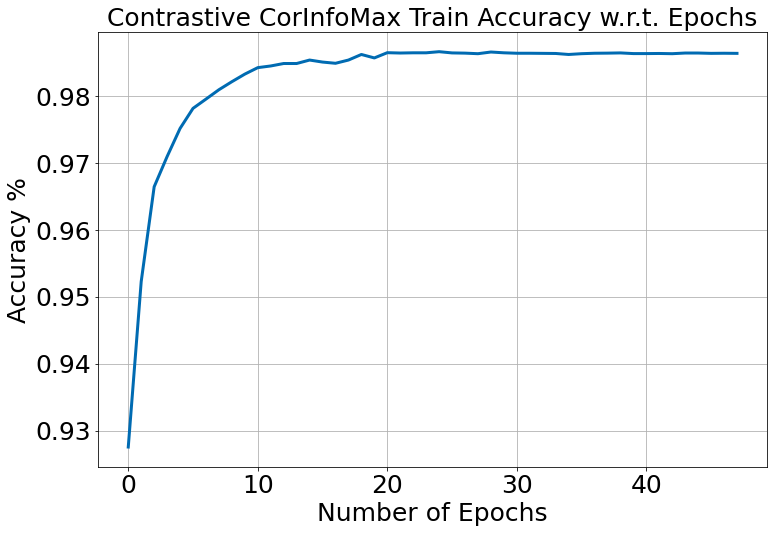

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

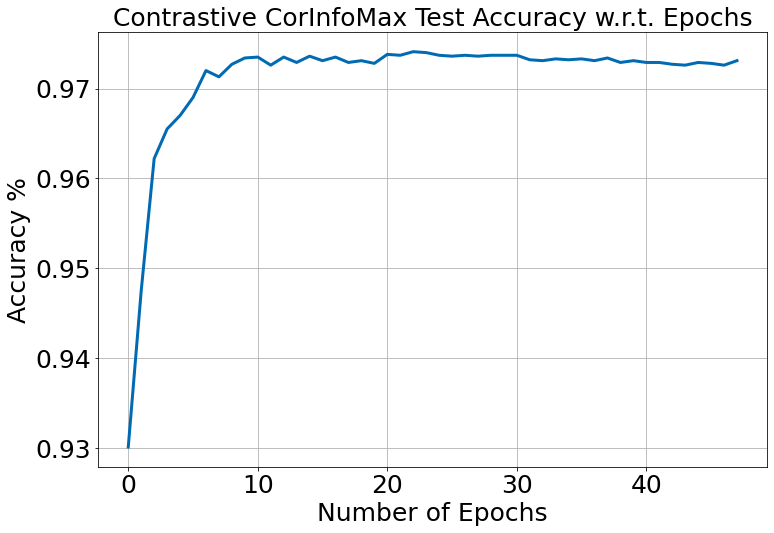

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [ ]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])